In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from typing import Optional, Union, List

In [10]:
df = pd.read_csv('Datasets/student-lifestyle.csv')

In [11]:
df.head()

,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,Stress_Level,Gender,Grades
0,1,6.9,3.8,8.7,2.8,1.8,Moderate,Male,7.48
1,2,5.3,3.5,8.0,4.2,3.0,Low,Female,6.88
2,3,5.1,3.9,9.2,1.2,4.6,Low,Male,6.68
3,4,6.5,2.1,7.2,1.7,6.5,Moderate,Male,7.20
4,5,8.1,0.6,6.5,2.2,6.6,High,Male,8.78


Number of possible anomalies: 441


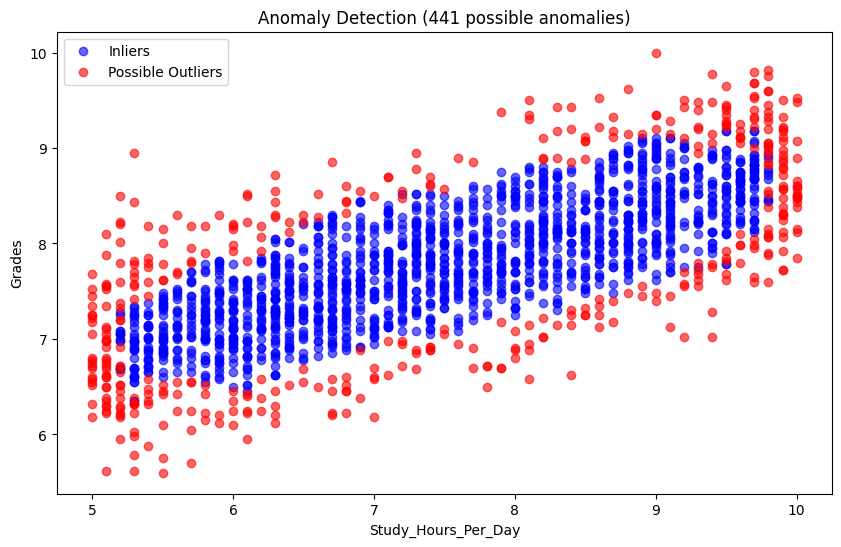

In [12]:
x_column = 'Study_Hours_Per_Day'
y_column = 'Grades'
X = df[[x_column, y_column]]

# Fit Isolation Forest
clf = IsolationForest(max_samples=len(X))
clf.fit(X)

# Predict anomalies
df['anomaly'] = clf.predict(X)

# Separate inliers and outliers
inliers = df[df['anomaly'] == 1]
outliers = df[df['anomaly'] == -1]

# Count the number of anomalies
num_anomalies = outliers.shape[0]
print(f"Number of possible anomalies: {num_anomalies}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(inliers[x_column], inliers[y_column], c='blue', label='Inliers', alpha=0.6)
plt.scatter(outliers[x_column], outliers[y_column], c='red', label='Possible Outliers', alpha=0.6)
plt.title(f"Anomaly Detection ({num_anomalies} possible anomalies)")
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.legend()
plt.show()

,Study_Hours_Per_Day,Grades,Anomaly Score
51,9.0,10.00,-0.250130
701,5.3,8.95,-0.224056
331,5.1,5.62,-0.207935
377,5.7,5.70,-0.190039
764,5.5,5.60,-0.180403


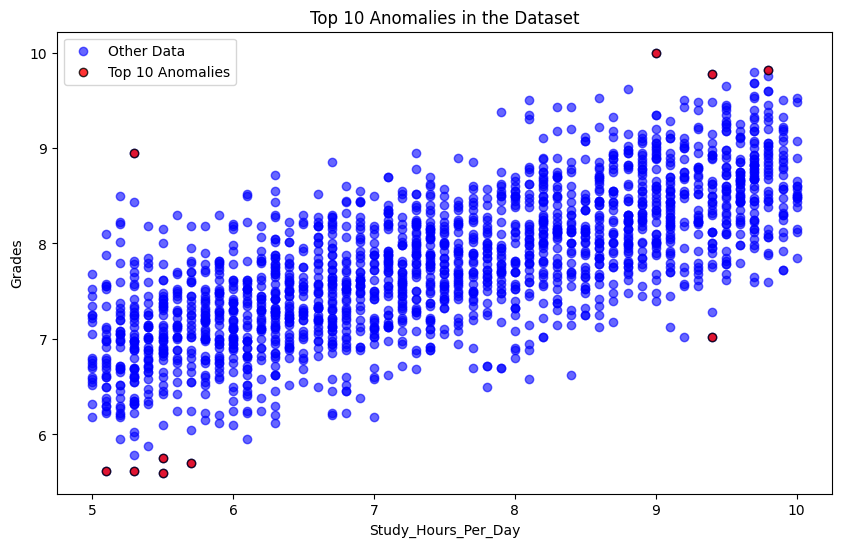

In [13]:
# Calculate anomaly scores
score = clf.decision_function(X)

# Create a DataFrame to store scores and corresponding data
data_scores = pd.DataFrame({
    x_column: X[x_column],
    y_column: X[y_column],
    'Anomaly Score': score
})


# Sort data_scores by 'Anomaly Score' in descending order
data_scores_sorted = data_scores.sort_values(by='Anomaly Score', ascending=True)

display(data_scores_sorted.head())

# Extract the top 10 anomalies
top_anomalies = data_scores_sorted.head(10)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot the rest of the data
plt.scatter(X[x_column], X[y_column], c='blue', label='Other Data', alpha=0.6)

# Plot the top 10 anomalies
plt.scatter(
    top_anomalies[x_column],
    top_anomalies[y_column],
    c='red',
    label='Top 10 Anomalies',
    alpha=0.8,
    edgecolor='black',
)

# Title and labels
plt.title("Top 10 Anomalies in the Dataset")
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.legend()
plt.show()


In [14]:
class IsolationTree:
    def __init__(self, max_depth: int) -> None:
        self.max_depth = max_depth
        self.split_feature = None
        self.split_value = None
        self.left = None
        self.right = None
        self.is_terminal = False
        self.size = 0

    def fit(self, X: np.ndarray, depth: int = 0) -> None:
        # Check the termination condition
        if depth >= self.max_depth or len(X) <= 1:
            self.is_terminal = True
            self.size = len(X)
            return

        # Randomly choose a feature and split value
        num_features = X.shape[1]
        self.split_feature = np.random.randint(0, num_features)
        min_val, max_val = np.min(X[:, self.split_feature]), np.max(X[:, self.split_feature])

        if min_val == max_val:  # No meaningful split
            self.is_terminal = True
            self.size = len(X)
            return

        self.split_value = np.random.uniform(min_val, max_val)

        # Partition the data
        left_mask = X[:, self.split_feature] < self.split_value # Mask for left subset
        right_mask = ~left_mask # Mask for right subset

        self.left = IsolationTree(self.max_depth)
        self.right = IsolationTree(self.max_depth)

        self.left.fit(X[left_mask], depth + 1)
        self.right.fit(X[right_mask], depth + 1)

    def path_length(self, X: np.ndarray) -> np.ndarray:
        path_lengths = np.zeros(X.shape[0])

        for i, x in enumerate(X):
            node = self
            depth = 0
            while not node.is_terminal: # Traverse tree until termianl node reached
                if x[node.split_feature] < node.split_value:
                    node = node.left
                else:
                    node = node.right
                depth += 1
            path_lengths[i] = depth + self._c(node.size)
        return path_lengths

    @staticmethod
    def _c(size: int) -> float:
        # Calculate average path length of a binary tree for given size
        if size <= 1:
            return 0
        return 2 * (np.log(size - 1) + 0.5772156649) - (2 * (size - 1) / size)


class IForest:
    def __init__(self, n_estimators: int = 100, max_samples: int = 256, max_depth: Optional[int] = None) -> None:
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.forest = []

    def fit(self, X: Union[np.ndarray, pd.DataFrame]) -> None:
        # Convert DataFrame to NumPy array if needed
        if isinstance(X, pd.DataFrame):
            X = X.values

        num_samples, num_features = X.shape
        self.max_samples = min(self.max_samples, num_samples)
        if self.max_depth is None:
            self.max_depth = int(np.ceil(np.log2(self.max_samples)))

        self.forest = []
        for _ in range(self.n_estimators):
            sample_indices = np.random.choice(num_samples, self.max_samples, replace=False)
            X_sample = X[sample_indices]
            tree = IsolationTree(self.max_depth)
            tree.fit(X_sample)
            self.forest.append(tree)

    def anomaly_score(self, X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray:
        # Convert DataFrame to NumPy array if needed
        if isinstance(X, pd.DataFrame):
            X = X.values

        path_lengths = np.zeros(X.shape[0])
        for tree in self.forest:
            path_lengths += tree.path_length(X)
        path_lengths /= len(self.forest)

        # Compute anomaly score based on path lengths
        c_n = 2 * (np.log(self.max_samples - 1) + 0.5772156649) - (2 * (self.max_samples - 1) / self.max_samples)
        scores = 2 ** (-path_lengths / c_n)
        return scores

    def predict(self, X: Union[np.ndarray, pd.DataFrame], threshold: float = 0.63) -> np.ndarray:
        scores = self.anomaly_score(X)
        print ('Mean:', np.mean(scores))
        return np.where(scores > threshold, -1, 1)

    def plot(self, X: Union[np.ndarray, pd.DataFrame], predictions: np.ndarray, feature_names: Optional[List[str]] = None) -> None:
        if isinstance(X, pd.DataFrame):
            X = X.values

        # Assign colors for anomalies and inliers
        colors = np.array(['blue' if p == 1 else 'red' for p in predictions])
        plt.figure(figsize=(10, 6))

        if X.shape[1] == 2:  # If data has 2 features
            plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.8)
            plt.xlabel(feature_names[0])
            plt.ylabel(feature_names[1])
        else:  # For more than 2 features, plot only the first two
            plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.8)
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
        plt.title('Isolation Forest - Anomaly Detection')
        plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Inliers'),
                            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Anomalies')],
                   loc='upper right')
        plt.grid()
        plt.show()

Mean: 0.48669074808773505


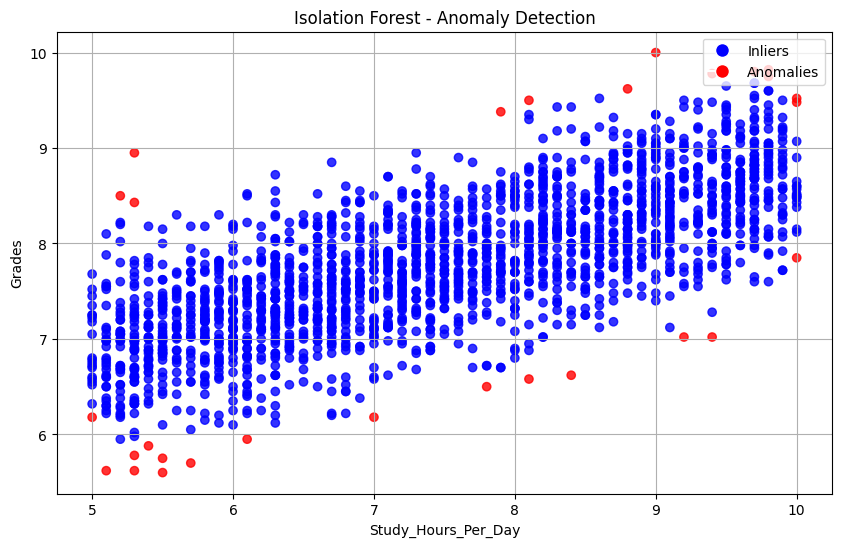

In [15]:
iforest = IForest(n_estimators=100, max_samples=len(df[['Study_Hours_Per_Day', 'Grades']]), max_depth=100)
iforest.fit(df[['Study_Hours_Per_Day', 'Grades']])

# Predict anomalies
scores = iforest.anomaly_score(df[['Study_Hours_Per_Day', 'Grades']])
predictions = iforest.predict(df[['Study_Hours_Per_Day', 'Grades']])

iforest.plot(df[['Study_Hours_Per_Day', 'Grades']], predictions, feature_names=['Study_Hours_Per_Day', 'Grades'])

Top 10 anomaly scores with corresponding IDs:
ID: 51, Anomaly Score: 0.7412062639436995
ID: 701, Anomaly Score: 0.7150176621966872
ID: 331, Anomaly Score: 0.7106958572613936
ID: 764, Anomaly Score: 0.686677405618194
ID: 377, Anomaly Score: 0.6765635332326011
ID: 1574, Anomaly Score: 0.6755205886588048
ID: 1763, Anomaly Score: 0.6731610068505322
ID: 1014, Anomaly Score: 0.6638239935098413
ID: 1454, Anomaly Score: 0.6569119149689919
ID: 118, Anomaly Score: 0.6539054979434215


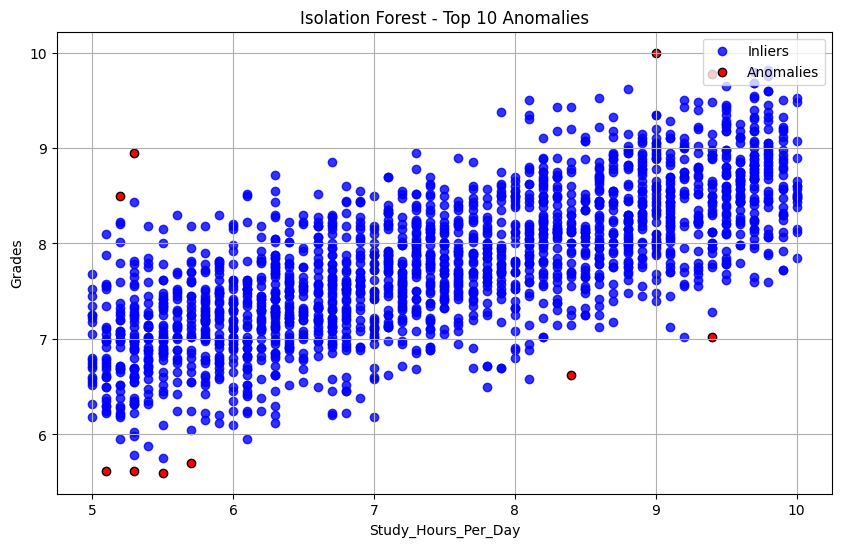

In [16]:
top_anomalies = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:10]  # Higher scores = more anomalous
top_anomaly_indices = [idx for idx, _ in top_anomalies]

print("Top 10 anomaly scores with corresponding IDs:")
for idx, score in top_anomalies:
    print(f"ID: {idx}, Anomaly Score: {score}")
        
plt.figure(figsize=(10, 6))

# Plot inliers
inlier_mask = ~df.index.isin(top_anomaly_indices)
plt.scatter(df.loc[inlier_mask, 'Study_Hours_Per_Day'], df.loc[inlier_mask, 'Grades'], color='blue', label='Inliers', alpha=0.8)

# Plot anomalies
plt.scatter(df.loc[top_anomaly_indices, 'Study_Hours_Per_Day'], df.loc[top_anomaly_indices, 'Grades'], color='red', label='Anomalies', edgecolor='k')

# Add labels and legend
plt.xlabel('Study_Hours_Per_Day')
plt.ylabel('Grades')
plt.title('Isolation Forest - Top 10 Anomalies')
plt.legend(loc='upper right')
plt.grid()
plt.show()